In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scandataset import SCANDataset
from scandataloader import SCANDataLoader
from transformer import Transformer
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from hyperparam_config.hyperparam_exp1 import *

In [2]:
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

device

'mps'

In [3]:
MAX_LEN = 50

src_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'walk',
    'look',
    'run',
    'jump',
    'turn',
    'left',
    'right',
    'and',
    'after',
    'opposite',
    'twice',
    'thrice',
    'around',
]

tgt_vocab = [
    '<PAD>',
    '<BOS>',
    '<EOS>',
    'I_WALK',
    'I_RUN',
    'I_JUMP',
    'I_LOOK',
    'I_TURN_RIGHT',
    'I_TURN_LEFT'
]

def list_to_dict(lst):
    return {k: v for v, k in enumerate(lst)}

src_vocab = list_to_dict(src_vocab)
tgt_vocab = list_to_dict(tgt_vocab)

paths = []

for exponent in range(7):
    pow2 = 2**exponent
    paths.append((
        os.path.join('data', 'simple_split', 'size_variations', f'tasks_train_simple_p{pow2}.txt'),
        os.path.join('data', 'simple_split', 'size_variations', f'tasks_test_simple_p{pow2}.txt')
    ))

paths.append((
    os.path.join('data', 'simple_split', f'tasks_train_simple.txt'),
    os.path.join('data', 'simple_split', f'tasks_test_simple.txt')
))

scandataloader = SCANDataLoader()

In [4]:
def train_loop(model, optimizer, criterion, dataloader, epochs):
    model.train()
    
    for epoch in tqdm.tqdm(range(epochs)):
        total_loss = 0
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            
            output = output.view(-1, output.shape[-1])
            tgt_output = tgt_output.reshape(-1)

            loss = criterion(output, tgt_output)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss/len(dataloader):.4f}")

In [5]:
def eval_loop(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            output = torch.argmax(output, -1)

            for i in range(output.size(0)):
                tgt_tokens = tgt_output[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy

In [6]:
def eval_loop_autoregressive(model, dataloader):
    model.eval()

    special_tokens = [tgt_vocab['<PAD>'], tgt_vocab['<BOS>'], tgt_vocab['<EOS>']]

    start_token = tgt_vocab['<BOS>']
    end_token = tgt_vocab['<EOS>']

    total_tokens = 0
    correct_tokens = 0
    total_seq = 0
    correct_seq = 0
    
    with torch.no_grad():
        for batch in dataloader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            output = model.predict(src, start_token, end_token, MAX_LEN)

            for i in range(output.size(0)):
                tgt_tokens = tgt[i].cpu().numpy()
                pred_tokens = output[i].cpu().numpy()

                for t, p in zip(tgt_tokens, pred_tokens):
                    if t not in special_tokens:
                        total_tokens += 1
                        if t == p:
                            correct_tokens += 1

                if all(t == p for t, p in zip(tgt_tokens, pred_tokens) if t not in special_tokens):
                    correct_seq += 1
                total_seq += 1

    token_accuracy = correct_tokens / total_tokens
    seq_accuracy = correct_seq / total_seq

    return token_accuracy, seq_accuracy

  5%|▌         | 1/20 [00:16<05:22, 16.99s/it]

Epoch 1, Loss: 2.0261


 10%|█         | 2/20 [00:28<04:07, 13.75s/it]

Epoch 2, Loss: 1.6084


 15%|█▌        | 3/20 [00:39<03:35, 12.67s/it]

Epoch 3, Loss: 1.4232


 20%|██        | 4/20 [00:51<03:14, 12.16s/it]

Epoch 4, Loss: 1.2681


 25%|██▌       | 5/20 [01:02<02:58, 11.88s/it]

Epoch 5, Loss: 1.0761


 30%|███       | 6/20 [01:14<02:44, 11.72s/it]

Epoch 6, Loss: 0.9856


 35%|███▌      | 7/20 [01:25<02:30, 11.60s/it]

Epoch 7, Loss: 0.8767


 40%|████      | 8/20 [01:36<02:19, 11.60s/it]

Epoch 8, Loss: 0.8384


 45%|████▌     | 9/20 [01:48<02:06, 11.54s/it]

Epoch 9, Loss: 0.7696


 50%|█████     | 10/20 [01:59<01:54, 11.48s/it]

Epoch 10, Loss: 0.7366


 55%|█████▌    | 11/20 [02:11<01:42, 11.43s/it]

Epoch 11, Loss: 0.7101


 60%|██████    | 12/20 [02:22<01:31, 11.43s/it]

Epoch 12, Loss: 0.6823


 65%|██████▌   | 13/20 [02:33<01:20, 11.44s/it]

Epoch 13, Loss: 0.6789


 70%|███████   | 14/20 [02:45<01:08, 11.47s/it]

Epoch 14, Loss: 0.6551


 75%|███████▌  | 15/20 [02:56<00:57, 11.41s/it]

Epoch 15, Loss: 0.6536


 80%|████████  | 16/20 [03:08<00:45, 11.38s/it]

Epoch 16, Loss: 0.6005


 85%|████████▌ | 17/20 [03:19<00:34, 11.40s/it]

Epoch 17, Loss: 0.6061


 90%|█████████ | 18/20 [03:30<00:22, 11.36s/it]

Epoch 18, Loss: 0.5855


 95%|█████████▌| 19/20 [03:42<00:11, 11.37s/it]

Epoch 19, Loss: 0.5565


100%|██████████| 20/20 [03:53<00:00, 11.67s/it]

Epoch 20, Loss: 0.5272


Token-level accuracy: 0.7499983141710779, Sequence-level accuracy: 0.0636201149702913


  5%|▌         | 1/20 [00:11<03:47, 11.96s/it]

Epoch 1, Loss: 1.8684


 10%|█         | 2/20 [00:23<03:29, 11.66s/it]

Epoch 2, Loss: 1.3945


 15%|█▌        | 3/20 [00:34<03:15, 11.53s/it]

Epoch 3, Loss: 1.1460


 20%|██        | 4/20 [00:46<03:04, 11.51s/it]

Epoch 4, Loss: 0.9588


 25%|██▌       | 5/20 [00:57<02:52, 11.53s/it]

Epoch 5, Loss: 0.8638


 30%|███       | 6/20 [01:09<02:41, 11.51s/it]

Epoch 6, Loss: 0.7949


 35%|███▌      | 7/20 [01:20<02:29, 11.46s/it]

Epoch 7, Loss: 0.7436


 40%|████      | 8/20 [01:32<02:17, 11.43s/it]

Epoch 8, Loss: 0.7008


 45%|████▌     | 9/20 [01:43<02:05, 11.44s/it]

Epoch 9, Loss: 0.6642


 50%|█████     | 10/20 [01:55<01:54, 11.47s/it]

Epoch 10, Loss: 0.6296


 55%|█████▌    | 11/20 [02:06<01:43, 11.50s/it]

Epoch 11, Loss: 0.6091


 60%|██████    | 12/20 [02:18<01:32, 11.52s/it]

Epoch 12, Loss: 0.5756


 65%|██████▌   | 13/20 [02:29<01:20, 11.48s/it]

Epoch 13, Loss: 0.5470


 70%|███████   | 14/20 [02:40<01:08, 11.46s/it]

Epoch 14, Loss: 0.5382


 75%|███████▌  | 15/20 [02:52<00:57, 11.45s/it]

Epoch 15, Loss: 0.5033


 80%|████████  | 16/20 [03:03<00:45, 11.48s/it]

Epoch 16, Loss: 0.4811


 85%|████████▌ | 17/20 [03:15<00:34, 11.45s/it]

Epoch 17, Loss: 0.4693


 90%|█████████ | 18/20 [03:26<00:22, 11.49s/it]

Epoch 18, Loss: 0.4448


 95%|█████████▌| 19/20 [03:38<00:11, 11.52s/it]

Epoch 19, Loss: 0.4257


100%|██████████| 20/20 [03:50<00:00, 11.51s/it]

Epoch 20, Loss: 0.4035


Token-level accuracy: 0.7943297162476224, Sequence-level accuracy: 0.07881124341206325


  5%|▌         | 1/20 [00:13<04:17, 13.57s/it]

Epoch 1, Loss: 1.6220


 10%|█         | 2/20 [00:26<03:56, 13.16s/it]

Epoch 2, Loss: 1.0337


 15%|█▌        | 3/20 [00:38<03:38, 12.84s/it]

Epoch 3, Loss: 0.8380


 20%|██        | 4/20 [00:51<03:22, 12.66s/it]

Epoch 4, Loss: 0.7609


 25%|██▌       | 5/20 [01:03<03:07, 12.51s/it]

Epoch 5, Loss: 0.7293


 30%|███       | 6/20 [01:15<02:54, 12.46s/it]

Epoch 6, Loss: 0.6761


 35%|███▌      | 7/20 [01:28<02:41, 12.42s/it]

Epoch 7, Loss: 0.6108


 40%|████      | 8/20 [01:40<02:29, 12.42s/it]

Epoch 8, Loss: 0.5615


 45%|████▌     | 9/20 [01:52<02:16, 12.37s/it]

Epoch 9, Loss: 0.5225


 50%|█████     | 10/20 [02:05<02:04, 12.44s/it]

Epoch 10, Loss: 0.4908


 55%|█████▌    | 11/20 [02:17<01:52, 12.45s/it]

Epoch 11, Loss: 0.4746


 60%|██████    | 12/20 [02:30<01:39, 12.40s/it]

Epoch 12, Loss: 0.4327


 65%|██████▌   | 13/20 [02:42<01:26, 12.37s/it]

Epoch 13, Loss: 0.3605


 70%|███████   | 14/20 [02:54<01:14, 12.38s/it]

Epoch 14, Loss: 0.3167


 75%|███████▌  | 15/20 [03:07<01:02, 12.40s/it]

Epoch 15, Loss: 0.2767


 80%|████████  | 16/20 [03:19<00:49, 12.38s/it]

Epoch 16, Loss: 0.2518


 85%|████████▌ | 17/20 [03:32<00:37, 12.37s/it]

Epoch 17, Loss: 0.2351


 90%|█████████ | 18/20 [03:44<00:24, 12.38s/it]

Epoch 18, Loss: 0.2145


 95%|█████████▌| 19/20 [03:57<00:12, 12.42s/it]

Epoch 19, Loss: 0.2066


100%|██████████| 20/20 [04:09<00:00, 12.47s/it]

Epoch 20, Loss: 0.1887


Token-level accuracy: 0.9284342028925089, Sequence-level accuracy: 0.3208129919298595


  5%|▌         | 1/20 [00:13<04:13, 13.36s/it]

Epoch 1, Loss: 1.3623


 10%|█         | 2/20 [00:26<03:54, 13.03s/it]

Epoch 2, Loss: 0.8138


 15%|█▌        | 3/20 [00:39<03:41, 13.00s/it]

Epoch 3, Loss: 0.6907


 20%|██        | 4/20 [00:51<03:26, 12.90s/it]

Epoch 4, Loss: 0.5989


 25%|██▌       | 5/20 [01:04<03:13, 12.89s/it]

Epoch 5, Loss: 0.5250


 30%|███       | 6/20 [01:17<02:59, 12.83s/it]

Epoch 6, Loss: 0.4618


 35%|███▌      | 7/20 [01:30<02:46, 12.79s/it]

Epoch 7, Loss: 0.4023


 40%|████      | 8/20 [01:42<02:33, 12.79s/it]

Epoch 8, Loss: 0.3376


 45%|████▌     | 9/20 [01:55<02:20, 12.78s/it]

Epoch 9, Loss: 0.2961


 50%|█████     | 10/20 [02:08<02:07, 12.77s/it]

Epoch 10, Loss: 0.2739


 55%|█████▌    | 11/20 [02:21<01:56, 12.91s/it]

Epoch 11, Loss: 0.2399


 60%|██████    | 12/20 [02:34<01:43, 12.90s/it]

Epoch 12, Loss: 0.2257


 65%|██████▌   | 13/20 [02:47<01:30, 12.92s/it]

Epoch 13, Loss: 0.2146


 70%|███████   | 14/20 [03:00<01:16, 12.83s/it]

Epoch 14, Loss: 0.1957


 75%|███████▌  | 15/20 [03:12<01:04, 12.83s/it]

Epoch 15, Loss: 0.1697


 80%|████████  | 16/20 [03:25<00:51, 12.81s/it]

Epoch 16, Loss: 0.1380


 85%|████████▌ | 17/20 [03:38<00:38, 12.80s/it]

Epoch 17, Loss: 0.1283


 90%|█████████ | 18/20 [03:51<00:25, 12.82s/it]

Epoch 18, Loss: 0.1139


 95%|█████████▌| 19/20 [04:04<00:12, 12.79s/it]

Epoch 19, Loss: 0.1076


100%|██████████| 20/20 [04:16<00:00, 12.84s/it]

Epoch 20, Loss: 0.1036


Token-level accuracy: 0.9755161086819378, Sequence-level accuracy: 0.7100530200644558


  5%|▌         | 1/20 [00:13<04:17, 13.57s/it]

Epoch 1, Loss: 1.0758


 10%|█         | 2/20 [00:27<04:03, 13.51s/it]

Epoch 2, Loss: 0.6551


 15%|█▌        | 3/20 [00:40<03:49, 13.48s/it]

Epoch 3, Loss: 0.5276


 20%|██        | 4/20 [00:54<03:36, 13.52s/it]

Epoch 4, Loss: 0.4018


 25%|██▌       | 5/20 [01:07<03:21, 13.44s/it]

Epoch 5, Loss: 0.2544


 30%|███       | 6/20 [01:20<03:09, 13.50s/it]

Epoch 6, Loss: 0.1792


 35%|███▌      | 7/20 [01:34<02:56, 13.55s/it]

Epoch 7, Loss: 0.1437


 40%|████      | 8/20 [01:48<02:42, 13.52s/it]

Epoch 8, Loss: 0.1137


 45%|████▌     | 9/20 [02:01<02:28, 13.48s/it]

Epoch 9, Loss: 0.0988


 50%|█████     | 10/20 [02:14<02:14, 13.46s/it]

Epoch 10, Loss: 0.0832


 55%|█████▌    | 11/20 [02:28<02:01, 13.45s/it]

Epoch 11, Loss: 0.0730


 60%|██████    | 12/20 [02:41<01:47, 13.43s/it]

Epoch 12, Loss: 0.0712


 65%|██████▌   | 13/20 [02:55<01:34, 13.52s/it]

Epoch 13, Loss: 0.0688


 70%|███████   | 14/20 [03:09<01:21, 13.58s/it]

Epoch 14, Loss: 0.0531


 75%|███████▌  | 15/20 [03:22<01:07, 13.54s/it]

Epoch 15, Loss: 0.0515


 80%|████████  | 16/20 [03:36<00:53, 13.50s/it]

Epoch 16, Loss: 0.0435


 85%|████████▌ | 17/20 [03:49<00:40, 13.46s/it]

Epoch 17, Loss: 0.0450


 90%|█████████ | 18/20 [04:02<00:26, 13.45s/it]

Epoch 18, Loss: 0.0361


 95%|█████████▌| 19/20 [04:16<00:13, 13.43s/it]

Epoch 19, Loss: 0.0309


100%|██████████| 20/20 [04:29<00:00, 13.48s/it]

Epoch 20, Loss: 0.0281


Token-level accuracy: 0.9966768824705551, Sequence-level accuracy: 0.9557073726159977


  5%|▌         | 1/20 [00:15<04:51, 15.36s/it]

Epoch 1, Loss: 0.8706


 10%|█         | 2/20 [00:30<04:32, 15.13s/it]

Epoch 2, Loss: 0.4856


 15%|█▌        | 3/20 [00:45<04:16, 15.08s/it]

Epoch 3, Loss: 0.3303


 20%|██        | 4/20 [01:00<03:58, 14.92s/it]

Epoch 4, Loss: 0.1934


 25%|██▌       | 5/20 [01:14<03:42, 14.82s/it]

Epoch 5, Loss: 0.1273


 30%|███       | 6/20 [01:29<03:26, 14.75s/it]

Epoch 6, Loss: 0.0947


 35%|███▌      | 7/20 [01:43<03:11, 14.72s/it]

Epoch 7, Loss: 0.0764


 40%|████      | 8/20 [01:58<02:56, 14.70s/it]

Epoch 8, Loss: 0.0588


 45%|████▌     | 9/20 [02:13<02:41, 14.68s/it]

Epoch 9, Loss: 0.0498


 50%|█████     | 10/20 [02:28<02:29, 14.91s/it]

Epoch 10, Loss: 0.0426


 55%|█████▌    | 11/20 [02:43<02:14, 14.91s/it]

Epoch 11, Loss: 0.0365


 60%|██████    | 12/20 [02:58<01:58, 14.87s/it]

Epoch 12, Loss: 0.0332


 65%|██████▌   | 13/20 [03:13<01:43, 14.83s/it]

Epoch 13, Loss: 0.0298


 70%|███████   | 14/20 [03:27<01:29, 14.84s/it]

Epoch 14, Loss: 0.0281


 75%|███████▌  | 15/20 [03:42<01:14, 14.82s/it]

Epoch 15, Loss: 0.0242


 80%|████████  | 16/20 [03:57<00:59, 14.81s/it]

Epoch 16, Loss: 0.0242


 85%|████████▌ | 17/20 [04:12<00:44, 14.78s/it]

Epoch 17, Loss: 0.0187


 90%|█████████ | 18/20 [04:26<00:29, 14.75s/it]

Epoch 18, Loss: 0.0181


 95%|█████████▌| 19/20 [04:41<00:14, 14.74s/it]

Epoch 19, Loss: 0.0158


100%|██████████| 20/20 [04:56<00:00, 14.82s/it]

Epoch 20, Loss: 0.0160


Token-level accuracy: 0.9975864961516386, Sequence-level accuracy: 0.9691258175680427


  5%|▌         | 1/20 [00:17<05:28, 17.28s/it]

Epoch 1, Loss: 0.6670


 10%|█         | 2/20 [00:34<05:06, 17.01s/it]

Epoch 2, Loss: 0.2017


 15%|█▌        | 3/20 [00:50<04:47, 16.94s/it]

Epoch 3, Loss: 0.0909


 20%|██        | 4/20 [01:07<04:29, 16.87s/it]

Epoch 4, Loss: 0.0560


 25%|██▌       | 5/20 [01:24<04:13, 16.88s/it]

Epoch 5, Loss: 0.0359


 30%|███       | 6/20 [01:41<03:56, 16.92s/it]

Epoch 6, Loss: 0.0276


 35%|███▌      | 7/20 [01:58<03:41, 17.04s/it]

Epoch 7, Loss: 0.0216


 40%|████      | 8/20 [02:15<03:23, 16.99s/it]

Epoch 8, Loss: 0.0168


 45%|████▌     | 9/20 [02:32<03:07, 17.06s/it]

Epoch 9, Loss: 0.0158


 50%|█████     | 10/20 [02:50<02:51, 17.14s/it]

Epoch 10, Loss: 0.0125


 55%|█████▌    | 11/20 [03:07<02:34, 17.12s/it]

Epoch 11, Loss: 0.0145


 60%|██████    | 12/20 [03:24<02:16, 17.10s/it]

Epoch 12, Loss: 0.0101


 65%|██████▌   | 13/20 [03:41<01:59, 17.13s/it]

Epoch 13, Loss: 0.0105


 70%|███████   | 14/20 [03:58<01:42, 17.11s/it]

Epoch 14, Loss: 0.0100


 75%|███████▌  | 15/20 [04:15<01:25, 17.05s/it]

Epoch 15, Loss: 0.0092


 80%|████████  | 16/20 [04:32<01:08, 17.03s/it]

Epoch 16, Loss: 0.0093


 85%|████████▌ | 17/20 [04:49<00:50, 16.97s/it]

Epoch 17, Loss: 0.0103


 90%|█████████ | 18/20 [05:06<00:34, 17.07s/it]

Epoch 18, Loss: 0.0058


 95%|█████████▌| 19/20 [05:24<00:17, 17.23s/it]

Epoch 19, Loss: 0.0083


100%|██████████| 20/20 [05:41<00:00, 17.09s/it]

Epoch 20, Loss: 0.0070


Token-level accuracy: 0.9998971780035707, Sequence-level accuracy: 0.998538788522848


  5%|▌         | 1/20 [00:18<06:00, 18.99s/it]

Epoch 1, Loss: 0.5497


 10%|█         | 2/20 [00:37<05:38, 18.82s/it]

Epoch 2, Loss: 0.1084


 15%|█▌        | 3/20 [00:56<05:17, 18.68s/it]

Epoch 3, Loss: 0.0532


 20%|██        | 4/20 [01:14<04:57, 18.57s/it]

Epoch 4, Loss: 0.0339


 25%|██▌       | 5/20 [01:33<04:39, 18.66s/it]

Epoch 5, Loss: 0.0268


 30%|███       | 6/20 [01:52<04:20, 18.64s/it]

Epoch 6, Loss: 0.0196


 35%|███▌      | 7/20 [02:10<04:01, 18.61s/it]

Epoch 7, Loss: 0.0151


 40%|████      | 8/20 [02:29<03:43, 18.62s/it]

Epoch 8, Loss: 0.0129


 45%|████▌     | 9/20 [02:47<03:24, 18.59s/it]

Epoch 9, Loss: 0.0118


 50%|█████     | 10/20 [03:06<03:05, 18.58s/it]

Epoch 10, Loss: 0.0097


 55%|█████▌    | 11/20 [03:25<02:47, 18.66s/it]

Epoch 11, Loss: 0.0093


 60%|██████    | 12/20 [03:43<02:29, 18.64s/it]

Epoch 12, Loss: 0.0080


 65%|██████▌   | 13/20 [04:02<02:10, 18.64s/it]

Epoch 13, Loss: 0.0101


 70%|███████   | 14/20 [04:21<01:52, 18.79s/it]

Epoch 14, Loss: 0.0067


 75%|███████▌  | 15/20 [04:40<01:33, 18.71s/it]

Epoch 15, Loss: 0.0076


 80%|████████  | 16/20 [04:58<01:14, 18.63s/it]

Epoch 16, Loss: 0.0062


 85%|████████▌ | 17/20 [05:17<00:55, 18.65s/it]

Epoch 17, Loss: 0.0057


 90%|█████████ | 18/20 [05:35<00:37, 18.59s/it]

Epoch 18, Loss: 0.0059


 95%|█████████▌| 19/20 [05:54<00:18, 18.60s/it]

Epoch 19, Loss: 0.0053


100%|██████████| 20/20 [06:13<00:00, 18.65s/it]

Epoch 20, Loss: 0.0076


Token-level accuracy: 0.999379402884938, Sequence-level accuracy: 0.994261119081779


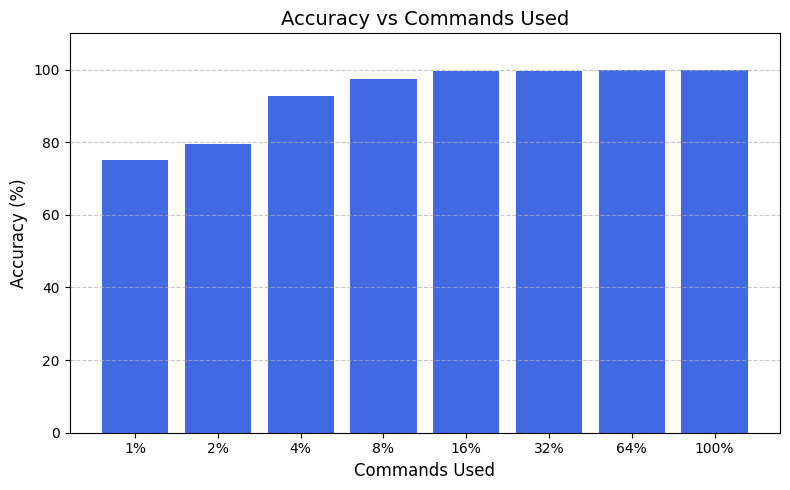

In [7]:
N = 8
epochs = 20
Y = []

for i in range(N):
    train_path, test_path = paths[i]

    train_data = scandataloader.load_file_path(train_path)
    test_data = scandataloader.load_file_path(test_path)

    dataset_train = SCANDataset(
        data=train_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataset_test = SCANDataset(
        data=test_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    train_loop(model, optimizer, criterion, dataloader_train, epochs)

    token_accuracy, seq_accuracy = eval_loop(model, dataloader_test)

    print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

    Y.append(token_accuracy * 100)

X = ['1%', '2%', '4%', '8%', '16%', '32%', '64%', '100%']

plt.figure(figsize=(8, 5))
plt.bar(X, Y, color='royalblue')
plt.xlabel('Commands Used', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 110)
plt.title('Accuracy vs Commands Used', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
N = 8
epochs = 20
Y = []

for i in range(N):
    train_path, test_path = paths[i]

    train_data = scandataloader.load_file_path(train_path)
    test_data = scandataloader.load_file_path(test_path)

    dataset_train = SCANDataset(
        data=train_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataset_test = SCANDataset(
        data=test_data,
        src_vocab=src_vocab,
        tgt_vocab=tgt_vocab,
        max_len=MAX_LEN,
    )

    dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    model = Transformer(
        src_vocab_size=len(src_vocab),
        tgt_vocab_size=len(tgt_vocab),
        src_pad_idx=src_vocab['<PAD>'],
        tgt_pad_idx=tgt_vocab['<PAD>'],
        emb_dim=EMB_DIM,
        num_layers=N_LAYERS,
        num_heads=N_HEADS,
        forward_dim=FORWARD_DIM,
        dropout=DROPOUT,
        max_len=MAX_LEN,
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab['<PAD>'])

    train_loop(model, optimizer, criterion, dataloader_train, epochs)

    token_accuracy, seq_accuracy = eval_loop_autoregressive(model, dataloader_test)

    print(f'Token-level accuracy: {token_accuracy}, Sequence-level accuracy: {seq_accuracy}')

    Y.append(token_accuracy * 100)

X = ['1%', '2%', '4%', '8%', '16%', '32%', '64%', '100%']

plt.figure(figsize=(8, 5))
plt.bar(X, Y, color='royalblue')
plt.xlabel('Commands Used', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 110)
plt.title('Accuracy vs Commands Used', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

  5%|▌         | 1/20 [00:11<03:37, 11.44s/it]

Epoch 1, Loss: 2.0590


 10%|█         | 2/20 [00:22<03:25, 11.43s/it]

Epoch 2, Loss: 1.6251


 15%|█▌        | 3/20 [00:34<03:15, 11.48s/it]

Epoch 3, Loss: 1.3907


 20%|██        | 4/20 [00:45<03:03, 11.46s/it]

Epoch 4, Loss: 1.2673


 25%|██▌       | 5/20 [00:57<02:52, 11.47s/it]

Epoch 5, Loss: 1.0813


 30%|███       | 6/20 [01:08<02:40, 11.49s/it]

Epoch 6, Loss: 1.0389


 35%|███▌      | 7/20 [01:20<02:29, 11.46s/it]

Epoch 7, Loss: 0.9425


 40%|████      | 8/20 [01:31<02:17, 11.42s/it]

Epoch 8, Loss: 0.8767


 45%|████▌     | 9/20 [01:43<02:05, 11.42s/it]

Epoch 9, Loss: 0.8165


 50%|█████     | 10/20 [01:54<01:54, 11.43s/it]

Epoch 10, Loss: 0.7911


 55%|█████▌    | 11/20 [02:05<01:42, 11.42s/it]

Epoch 11, Loss: 0.7701


 60%|██████    | 12/20 [02:17<01:31, 11.42s/it]

Epoch 12, Loss: 0.7117


 65%|██████▌   | 13/20 [02:28<01:20, 11.44s/it]

Epoch 13, Loss: 0.6744


 70%|███████   | 14/20 [02:40<01:08, 11.48s/it]

Epoch 14, Loss: 0.6914


 75%|███████▌  | 15/20 [02:51<00:57, 11.48s/it]

Epoch 15, Loss: 0.6456


 80%|████████  | 16/20 [03:03<00:45, 11.43s/it]

Epoch 16, Loss: 0.6325


 85%|████████▌ | 17/20 [03:14<00:34, 11.40s/it]

Epoch 17, Loss: 0.5924


 90%|█████████ | 18/20 [03:25<00:22, 11.43s/it]

Epoch 18, Loss: 0.5546


 95%|█████████▌| 19/20 [03:37<00:11, 11.48s/it]

Epoch 19, Loss: 0.5418


100%|██████████| 20/20 [03:48<00:00, 11.45s/it]

Epoch 20, Loss: 0.5561


Token-level accuracy: 0.5673151488586938, Sequence-level accuracy: 0.06811265156272645


  5%|▌         | 1/20 [00:11<03:39, 11.57s/it]

Epoch 1, Loss: 1.8018


 10%|█         | 2/20 [00:23<03:27, 11.50s/it]

Epoch 2, Loss: 1.3670


 15%|█▌        | 3/20 [00:34<03:15, 11.50s/it]

Epoch 3, Loss: 1.1068


 20%|██        | 4/20 [00:45<03:03, 11.48s/it]

Epoch 4, Loss: 0.9302


 25%|██▌       | 5/20 [00:57<02:52, 11.49s/it]

Epoch 5, Loss: 0.8481


 30%|███       | 6/20 [01:09<02:41, 11.52s/it]

Epoch 6, Loss: 0.7853


 35%|███▌      | 7/20 [01:20<02:29, 11.52s/it]

Epoch 7, Loss: 0.7492


 40%|████      | 8/20 [01:32<02:18, 11.51s/it]

Epoch 8, Loss: 0.7041


 45%|████▌     | 9/20 [01:43<02:06, 11.49s/it]

Epoch 9, Loss: 0.6651


 50%|█████     | 10/20 [01:55<01:55, 11.51s/it]

Epoch 10, Loss: 0.6309


 55%|█████▌    | 11/20 [02:06<01:43, 11.52s/it]

Epoch 11, Loss: 0.6040


 60%|██████    | 12/20 [02:18<01:31, 11.50s/it]

Epoch 12, Loss: 0.5772


 65%|██████▌   | 13/20 [02:29<01:20, 11.49s/it]

Epoch 13, Loss: 0.5398


 70%|███████   | 14/20 [02:41<01:08, 11.50s/it]

Epoch 14, Loss: 0.5195


 75%|███████▌  | 15/20 [02:52<00:57, 11.49s/it]

Epoch 15, Loss: 0.4912


 80%|████████  | 16/20 [03:03<00:45, 11.48s/it]

Epoch 16, Loss: 0.4718


 85%|████████▌ | 17/20 [03:15<00:34, 11.48s/it]

Epoch 17, Loss: 0.4557


 90%|█████████ | 18/20 [03:26<00:22, 11.46s/it]

Epoch 18, Loss: 0.4356


 95%|█████████▌| 19/20 [03:38<00:11, 11.52s/it]

Epoch 19, Loss: 0.4181


100%|██████████| 20/20 [03:50<00:00, 11.51s/it]

Epoch 20, Loss: 0.4093


Token-level accuracy: 0.5471667296168884, Sequence-level accuracy: 0.056900253757563926


  5%|▌         | 1/20 [00:12<04:05, 12.91s/it]

Epoch 1, Loss: 1.6526


 10%|█         | 2/20 [00:25<03:49, 12.73s/it]

Epoch 2, Loss: 1.0953


 15%|█▌        | 3/20 [00:37<03:33, 12.59s/it]

Epoch 3, Loss: 0.8475


 20%|██        | 4/20 [00:50<03:21, 12.57s/it]

Epoch 4, Loss: 0.7655


 25%|██▌       | 5/20 [01:02<03:08, 12.55s/it]

Epoch 5, Loss: 0.7203


 30%|███       | 6/20 [01:15<02:57, 12.66s/it]

Epoch 6, Loss: 0.6462


 35%|███▌      | 7/20 [01:28<02:44, 12.68s/it]

Epoch 7, Loss: 0.5978


 40%|████      | 8/20 [01:41<02:31, 12.64s/it]

Epoch 8, Loss: 0.5518


 45%|████▌     | 9/20 [01:53<02:19, 12.65s/it]

Epoch 9, Loss: 0.5182


 50%|█████     | 10/20 [02:06<02:05, 12.57s/it]

Epoch 10, Loss: 0.5005


 55%|█████▌    | 11/20 [02:18<01:52, 12.53s/it]

Epoch 11, Loss: 0.4726


 60%|██████    | 12/20 [02:31<01:40, 12.52s/it]

Epoch 12, Loss: 0.4227


 65%|██████▌   | 13/20 [02:43<01:27, 12.47s/it]

Epoch 13, Loss: 0.3847


 70%|███████   | 14/20 [02:56<01:15, 12.50s/it]

Epoch 14, Loss: 0.3535


 75%|███████▌  | 15/20 [03:08<01:02, 12.45s/it]

Epoch 15, Loss: 0.3094


 80%|████████  | 16/20 [03:20<00:49, 12.44s/it]

Epoch 16, Loss: 0.2762


 85%|████████▌ | 17/20 [03:33<00:37, 12.40s/it]

Epoch 17, Loss: 0.2449


 90%|█████████ | 18/20 [03:45<00:24, 12.38s/it]

Epoch 18, Loss: 0.2348


 95%|█████████▌| 19/20 [03:57<00:12, 12.37s/it]

Epoch 19, Loss: 0.2176


100%|██████████| 20/20 [04:10<00:00, 12.51s/it]

Epoch 20, Loss: 0.1888


Token-level accuracy: 0.7352412913804903, Sequence-level accuracy: 0.2759788781508419


  5%|▌         | 1/20 [00:12<04:04, 12.85s/it]

Epoch 1, Loss: 1.3699


 10%|█         | 2/20 [00:25<03:50, 12.80s/it]

Epoch 2, Loss: 0.8277


 15%|█▌        | 3/20 [00:38<03:36, 12.74s/it]

Epoch 3, Loss: 0.7070


 20%|██        | 4/20 [00:51<03:23, 12.75s/it]

Epoch 4, Loss: 0.6190


 25%|██▌       | 5/20 [01:03<03:10, 12.71s/it]

Epoch 5, Loss: 0.5440


 30%|███       | 6/20 [01:16<02:57, 12.70s/it]

Epoch 6, Loss: 0.4893


 35%|███▌      | 7/20 [01:29<02:45, 12.71s/it]

Epoch 7, Loss: 0.4441


 40%|████      | 8/20 [01:41<02:32, 12.69s/it]

Epoch 8, Loss: 0.3863


 45%|████▌     | 9/20 [01:54<02:19, 12.70s/it]

Epoch 9, Loss: 0.2901


 50%|█████     | 10/20 [02:06<02:06, 12.65s/it]

Epoch 10, Loss: 0.2392


 55%|█████▌    | 11/20 [02:19<01:54, 12.68s/it]

Epoch 11, Loss: 0.2088


 60%|██████    | 12/20 [02:32<01:41, 12.69s/it]

Epoch 12, Loss: 0.1777


 65%|██████▌   | 13/20 [02:45<01:28, 12.69s/it]

Epoch 13, Loss: 0.1589


 70%|███████   | 14/20 [02:57<01:15, 12.65s/it]

Epoch 14, Loss: 0.1453


 75%|███████▌  | 15/20 [03:10<01:03, 12.68s/it]

Epoch 15, Loss: 0.1291


 80%|████████  | 16/20 [03:23<00:50, 12.68s/it]

Epoch 16, Loss: 0.1201


 85%|████████▌ | 17/20 [03:35<00:38, 12.68s/it]

Epoch 17, Loss: 0.1138


 90%|█████████ | 18/20 [03:48<00:25, 12.67s/it]

Epoch 18, Loss: 0.1095


 95%|█████████▌| 19/20 [04:01<00:12, 12.69s/it]

Epoch 19, Loss: 0.0955


100%|██████████| 20/20 [04:13<00:00, 12.70s/it]

Epoch 20, Loss: 0.0838


Token-level accuracy: 0.9261386296562176, Sequence-level accuracy: 0.7049069549849256


  5%|▌         | 1/20 [00:13<04:18, 13.61s/it]

Epoch 1, Loss: 1.0809


 10%|█         | 2/20 [00:26<04:00, 13.36s/it]

Epoch 2, Loss: 0.6763


 15%|█▌        | 3/20 [00:40<03:47, 13.36s/it]

Epoch 3, Loss: 0.5328


 20%|██        | 4/20 [00:53<03:34, 13.40s/it]

Epoch 4, Loss: 0.3966


 25%|██▌       | 5/20 [01:06<03:20, 13.38s/it]

Epoch 5, Loss: 0.2560


 30%|███       | 6/20 [01:20<03:07, 13.37s/it]

Epoch 6, Loss: 0.1969


 35%|███▌      | 7/20 [01:33<02:53, 13.38s/it]

Epoch 7, Loss: 0.1554


 40%|████      | 8/20 [01:47<02:40, 13.39s/it]

Epoch 8, Loss: 0.1282


 45%|████▌     | 9/20 [02:00<02:27, 13.38s/it]

Epoch 9, Loss: 0.1052


 50%|█████     | 10/20 [02:13<02:13, 13.38s/it]

Epoch 10, Loss: 0.0949


 55%|█████▌    | 11/20 [02:27<02:00, 13.41s/it]

Epoch 11, Loss: 0.0843


 60%|██████    | 12/20 [02:40<01:47, 13.40s/it]

Epoch 12, Loss: 0.0721


 65%|██████▌   | 13/20 [02:54<01:33, 13.42s/it]

Epoch 13, Loss: 0.0649


 70%|███████   | 14/20 [03:07<01:20, 13.40s/it]

Epoch 14, Loss: 0.0630


 75%|███████▌  | 15/20 [03:20<01:06, 13.33s/it]

Epoch 15, Loss: 0.0521


 80%|████████  | 16/20 [03:34<00:53, 13.33s/it]

Epoch 16, Loss: 0.0500


 85%|████████▌ | 17/20 [03:47<00:40, 13.35s/it]

Epoch 17, Loss: 0.0458


 90%|█████████ | 18/20 [04:00<00:26, 13.33s/it]

Epoch 18, Loss: 0.0402


 95%|█████████▌| 19/20 [04:13<00:13, 13.28s/it]

Epoch 19, Loss: 0.0353


100%|██████████| 20/20 [04:27<00:00, 13.37s/it]

Epoch 20, Loss: 0.0339


Token-level accuracy: 0.9861589769886037, Sequence-level accuracy: 0.9286649587247366


  5%|▌         | 1/20 [00:15<04:48, 15.20s/it]

Epoch 1, Loss: 0.8847


 10%|█         | 2/20 [00:29<04:26, 14.81s/it]

Epoch 2, Loss: 0.4785


 15%|█▌        | 3/20 [00:44<04:12, 14.87s/it]

Epoch 3, Loss: 0.2881


 20%|██        | 4/20 [00:59<03:58, 14.88s/it]

Epoch 4, Loss: 0.1539


 25%|██▌       | 5/20 [01:13<03:40, 14.71s/it]

Epoch 5, Loss: 0.1040


 30%|███       | 6/20 [01:29<03:27, 14.83s/it]

Epoch 6, Loss: 0.0767


 35%|███▌      | 7/20 [01:43<03:12, 14.84s/it]

Epoch 7, Loss: 0.0635


 40%|████      | 8/20 [01:58<02:58, 14.86s/it]

Epoch 8, Loss: 0.0522


 45%|████▌     | 9/20 [02:13<02:43, 14.87s/it]

Epoch 9, Loss: 0.0435


 50%|█████     | 10/20 [02:28<02:29, 14.94s/it]

Epoch 10, Loss: 0.0377


 55%|█████▌    | 11/20 [02:43<02:14, 14.93s/it]

Epoch 11, Loss: 0.0301


 60%|██████    | 12/20 [02:59<02:00, 15.10s/it]

Epoch 12, Loss: 0.0282


 65%|██████▌   | 13/20 [03:14<01:46, 15.22s/it]

Epoch 13, Loss: 0.0243


 70%|███████   | 14/20 [03:29<01:30, 15.00s/it]

Epoch 14, Loss: 0.0233


 75%|███████▌  | 15/20 [03:43<01:14, 14.94s/it]

Epoch 15, Loss: 0.0234


 80%|████████  | 16/20 [03:59<00:59, 14.98s/it]

Epoch 16, Loss: 0.0162


 85%|████████▌ | 17/20 [04:13<00:44, 14.93s/it]

Epoch 17, Loss: 0.0163


 90%|█████████ | 18/20 [04:28<00:29, 14.86s/it]

Epoch 18, Loss: 0.0162


 95%|█████████▌| 19/20 [04:43<00:14, 14.83s/it]

Epoch 19, Loss: 0.0142


100%|██████████| 20/20 [04:58<00:00, 14.91s/it]

Epoch 20, Loss: 0.0157


Token-level accuracy: 0.9947020647231093, Sequence-level accuracy: 0.9737674941979042


  5%|▌         | 1/20 [00:18<05:46, 18.21s/it]

Epoch 1, Loss: 0.6310


 10%|█         | 2/20 [00:35<05:22, 17.92s/it]

Epoch 2, Loss: 0.2114


 15%|█▌        | 3/20 [00:53<05:02, 17.82s/it]

Epoch 3, Loss: 0.1003


 20%|██        | 4/20 [01:10<04:42, 17.63s/it]

Epoch 4, Loss: 0.0665


 25%|██▌       | 5/20 [01:28<04:24, 17.65s/it]

Epoch 5, Loss: 0.0487


 30%|███       | 6/20 [01:46<04:08, 17.72s/it]

Epoch 6, Loss: 0.0341


 35%|███▌      | 7/20 [02:04<03:49, 17.68s/it]

Epoch 7, Loss: 0.0263


 40%|████      | 8/20 [02:21<03:31, 17.66s/it]

Epoch 8, Loss: 0.0247


 45%|████▌     | 9/20 [02:39<03:15, 17.79s/it]

Epoch 9, Loss: 0.0193


 50%|█████     | 10/20 [02:57<02:58, 17.83s/it]

Epoch 10, Loss: 0.0175


 55%|█████▌    | 11/20 [03:14<02:38, 17.66s/it]

Epoch 11, Loss: 0.0142


 60%|██████    | 12/20 [03:32<02:21, 17.64s/it]

Epoch 12, Loss: 0.0134


 65%|██████▌   | 13/20 [03:49<02:02, 17.56s/it]

Epoch 13, Loss: 0.0105


 70%|███████   | 14/20 [04:07<01:45, 17.52s/it]

Epoch 14, Loss: 0.0109


 75%|███████▌  | 15/20 [04:24<01:27, 17.44s/it]

Epoch 15, Loss: 0.0086
